In [1]:
# import torch
# torch_version = torch.__version__.split('+')[0]  # e.g., '2.1.0'
# url = f"https://data.pyg.org/whl/torch-{torch_version}.html"

# Now install with pip
# !pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f {url}


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import random
import os

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.neighbors import kneighbors_graph


In [3]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)

seedEverything(2021)

In [4]:
# url = "https://raw.githubusercontent.com/akashvenus/Final_Project/refs/heads/main/sets1/train.csv"
df = pd.read_csv("train.csv")
df

,Unnamed: 0,destination port,flow duration,total fwd packets,total backward packets,total length of fwd packets,total length of bwd packets,fwd packet length max,fwd packet length min,fwd packet length mean,...,min_seg_size_forward,active mean,active std,active max,active min,idle mean,idle std,idle max,idle min,label
0,87113,443,3528693,12,11,999,3950,267,0,83.25,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,74766,443,2569280,2,0,12,0,6,6,6.00,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,204834,61478,89,1,2,6,12,6,6,6.00,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,160785,65091,79,1,3,0,18,0,0,0.00,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,236828,53,214,2,2,68,484,34,34,34.00,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171787,133741,53,172,2,2,76,140,38,38,38.00,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
171788,214144,53,67102,2,2,84,182,42,42,42.00,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
171789,137273,53,30248,1,1,50,78,50,50,50.00,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
171790,224597,80,970,2,0,0,0,0,0,0.00,...,32,0.0,0.0,0,0,0.0,0.0,0,0,DoS Hulk


In [5]:
df['label'] = df['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [6]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [7]:
import joblib

scaler = joblib.load("scaler.pkl")

In [8]:
X = df[scaler.feature_names_in_]
y = df['label'].values
num_nodes = len(df)

In [9]:
X_scaled = scaler.transform(X)

In [10]:
train_idx_np, test_idx_np = train_test_split(
    np.arange(num_nodes),
    test_size=0.33,
    stratify=y,
    random_state=DEFAULT_RANDOM_SEED
)

In [11]:
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx_np] = True

In [12]:
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[test_idx_np] = True

In [13]:
k = 5
knn_graph = kneighbors_graph(X_scaled, n_neighbors=k, include_self=False)

row_idx, col_idx = knn_graph.nonzero()
edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)

# Convert to PyG data
x = torch.tensor(X_scaled, dtype=torch.float)
y_torch = torch.tensor(y, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y_torch)
print(data)

d:\Documents\GitHub\Final_Project\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Documents\GitHub\Final_Project\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program 

Data(x=[171792, 78], edge_index=[2, 858960], y=[171792])


C:\Users\Arild\AppData\Local\Temp\ipykernel_19344\4049555578.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  edge_index = torch.tensor([row_idx, col_idx], dtype=torch.long)


In [22]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class GraphNet(nn.Module):
    def __init__(self, in_channels, gcn_hidden, dnn_hidden, out_channels):
        super().__init__()
        # -- GNN layers --
        self.gcn1 = GCNConv(in_channels, gcn_hidden)
        self.gcn2 = GCNConv(gcn_hidden, gcn_hidden)

        # -- DNN layers --
        self.lin1 = nn.Linear(gcn_hidden, dnn_hidden)
        self.lin2 = nn.Linear(dnn_hidden, out_channels)

    def forward(self, x, edge_index):
        # ----- GNN stage -----
        x = self.gcn1(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)
        x = self.gcn2(x, edge_index)   # shape: [num_nodes, gcn_hidden]
        x = F.relu(x)

        # ----- DNN stage -----
        x = self.lin1(x)              # shape: [num_nodes, dnn_hidden]
        x = F.relu(x)
        x = self.lin2(x)              # shape: [num_nodes, out_channels]

        return F.log_softmax(x, dim=1) # for multi-class or binary classification

model = GraphNet(
    in_channels=x.shape[1],  # number of features
    gcn_hidden=128,           # size of GCN hidden embeddings
    dnn_hidden=64,           # size of hidden layer in the MLP
    out_channels=2           # final classes (0=Benign, 1=Attack)
)


loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [23]:
epochs = 80
for epoch in range(1, epochs+1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)  # shape: [num_nodes, 2]

    # Compute loss on train_mask only
    loss = loss_fn(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    # Evaluate on test set
    if epoch % 10 == 0 or epoch == epochs:
        model.eval()
        with torch.no_grad():
            out_test = out[test_mask]
            pred_test = out_test.argmax(dim=1)
            y_true_test = data.y[test_mask]

            acc = accuracy_score(y_true_test.cpu(), pred_test.cpu())
            print(f"Epoch {epoch}/{epochs} | Loss: {loss.item():.4f} | Test Accuracy: {acc:.4f}")


Epoch 10/80 | Loss: 0.1707 | Test Accuracy: 0.9118
Epoch 20/80 | Loss: 0.1108 | Test Accuracy: 0.9531
Epoch 30/80 | Loss: 0.0943 | Test Accuracy: 0.9571
Epoch 40/80 | Loss: 0.0829 | Test Accuracy: 0.9616
Epoch 50/80 | Loss: 0.0728 | Test Accuracy: 0.9681
Epoch 60/80 | Loss: 0.0696 | Test Accuracy: 0.9687
Epoch 70/80 | Loss: 0.0739 | Test Accuracy: 0.9636
Epoch 80/80 | Loss: 0.0655 | Test Accuracy: 0.9727


In [24]:
model.eval()
with torch.no_grad():
    out_all = model(data.x, data.edge_index)
    pred_all = out_all.argmax(dim=1)

    # Evaluate on test_mask
    y_true_test = data.y[test_mask]
    y_pred_test = pred_all[test_mask]

    # Basic metrics
    acc_test  = accuracy_score(y_true_test.cpu(), y_pred_test.cpu())
    prec_test = precision_score(y_true_test.cpu(), y_pred_test.cpu(), average='binary')
    rec_test  = recall_score(y_true_test.cpu(), y_pred_test.cpu(), average='binary')
    f1_test   = f1_score(y_true_test.cpu(), y_pred_test.cpu(), average='binary')

    tn, fp, fn, tp = confusion_matrix(y_true_test.cpu(), y_pred_test.cpu()).ravel()
    fpr_test = fp / (fp + tn)

    print("\nFinal Test Metrics (Node-Level Classification):")
    print("-----------------------------------------------")
    print(f"Accuracy:    {acc_test:.4f}")
    print(f"Precision:   {prec_test:.4f}")
    print(f"Recall:      {rec_test:.4f}")
    print(f"F1-Score:    {f1_test:.4f}")
    print(f"False Pos Rate (FPR): {fpr_test:.4f}")
    print(classification_report(y_true_test.cpu(), y_pred_test.cpu(), target_names=['Benign (0)', 'Attack (1)']))


Final Test Metrics (Node-Level Classification):
-----------------------------------------------
Accuracy:    0.9738
Precision:   0.9296
Recall:      0.9279
F1-Score:    0.9288
False Pos Rate (FPR): 0.0158
              precision    recall  f1-score   support

  Benign (0)       0.98      0.98      0.98     46273
  Attack (1)       0.93      0.93      0.93     10419

    accuracy                           0.97     56692
   macro avg       0.96      0.96      0.96     56692
weighted avg       0.97      0.97      0.97     56692



We trained and tested the GNN+DNN in the above steps

In [17]:
torch.save(model.state_dict(), "GNN_DNN_weights.pth")


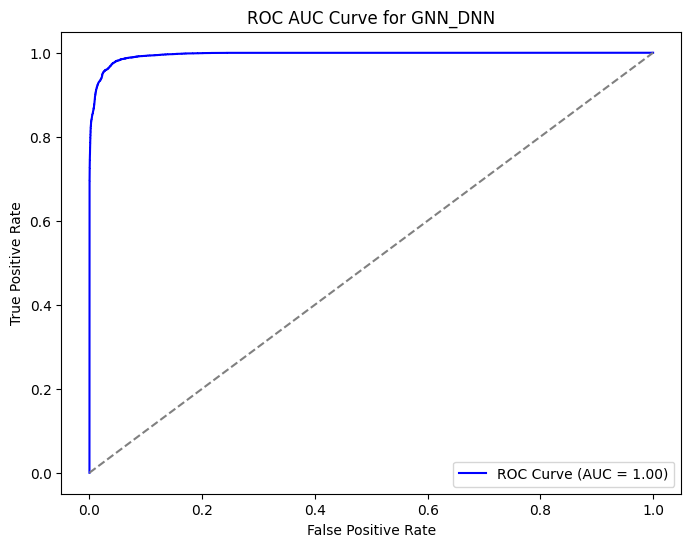

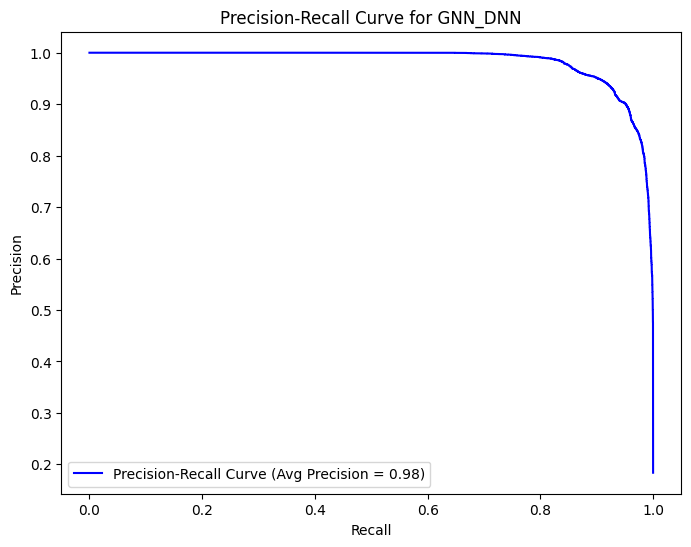

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc,  average_precision_score

model_name = "GNN_DNN"

with torch.no_grad():
    out_prob = out_all.exp()               # Convert from log-probs to probabilities
    y_proba_test = out_prob[test_mask, 1]  # Probability of class=1 for test nodes

# Convert to numpy arrays
y_true_test_np = y_true_test.cpu().numpy()
y_proba_test_np = y_proba_test.cpu().numpy()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_test_np, y_proba_test_np)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC AUC Curve for {model_name}')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_test_np, y_proba_test_np)
avg_precision = average_precision_score(y_true_test_np, y_proba_test_np)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue',
         label=f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve for {model_name}')
plt.legend(loc='lower left')
plt.show()
